In [1]:
import numpy as np
import xarray as xr
import gsw
import time 
from datetime import datetime
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs 
import cmocean
from scipy.interpolate import interp1d 
import scipy.ndimage as si
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# load file 
filename = ('/Users/jakesteinberg/Documents/CPT/j2_filtered.nc')
j2_filtered = xr.open_dataset(filename)
total_ke = j2_filtered['total_ke'].data
filtered_ke = j2_filtered['filtered_ke'].data
eke = j2_filtered['eke'].data
frac_year = j2_filtered['frac_year'].data
lon_bin_c = j2_filtered.lon.longitude.data
lat_bin_c = j2_filtered.lat.latitude.data
coarsening_factors = j2_filtered.filter_fac.filter_fac.data
s_i = j2_filtered['month_bins'].data

In [245]:
# load climatology
f_argo_pe = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APE.nc'
argo_pe = xr.open_dataset(f_argo_pe)
pe_lon = argo_pe.lon.longitude.data
pe_lat = argo_pe.lat.latitude.data
pe = argo_pe['pe'].data
ape_rate = argo_pe['ape_rate'].data

In [246]:
np.shape(pe)

(12, 145, 360)

In [243]:
# global parameters/fields 
hor_grid_spacing = 20.0
lon_bins = np.arange(0,361)
lat_bins = np.arange(-70,71)
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
# colors = ['#191970', '#DAA520', '#808000', '#8B0000', 'c', 'm']
colors = ['#79B791', '#086788', '#F0C808', '#DC493A', '#664147', 'm', '#FF8C00']
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream','Eastern S. Pac.']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34], [248, 252, -40, -36]])

In [257]:
0.5*np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) \
                                  /np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]])

array([0.79966839, 1.37697366, 1.42155144, 1.0978489 , 0.50435883,
       0.16822289, 0.03157129, 0.02383429, 0.04234323, 0.03078296,
       0.04100868, 0.24427638])

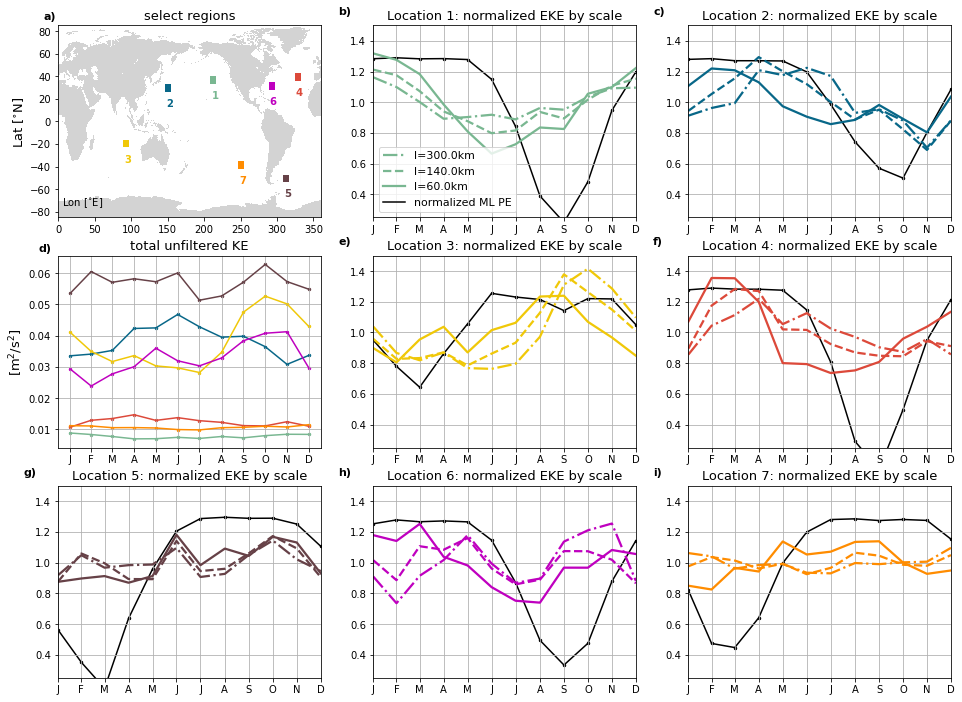

In [268]:
# seasonality in EKE 
x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/landmask2.nc') 
land_cmap = plt.cm.get_cmap('viridis')
land_cmap.set_over('#D3D3D3') #FFDEAD
land_cmap.set_under('w')
# ---
f, ax = plt.subplots(3, 3, figsize = (16, 12))
ax[0,0].pcolor(x4['lon'].values, x4['lat'].values, x4['landMask'].values, vmin=0.2, vmax=0.3, cmap=land_cmap)
in_lon = []
in_lat = []
in_lon_pe = []
in_lat_pe = []
for i in [0,1,2,3,4,5,6]:  # range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax[0,0].plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    # if i < 4:
    ax[0,0].text(this_lon0, this_lat0 - 15, str(i + 1), fontsize=10, color=colors[i], fontweight='bold')
    in_lon.append(np.where((lon_bin_c > this_lon0) & (lon_bin_c < this_lon1))[0])
    in_lat.append(np.where((lat_bin_c > this_lat0) & (lat_bin_c < this_lat1))[0])
    in_lon_pe.append(np.where((pe_lon > this_lon0) & (pe_lon < this_lon1))[0])
    in_lat_pe.append(np.where((pe_lat > this_lat0) & (pe_lat < this_lat1))[0])

ax[0,0].set_xlim([lon_w, lon_e])
ax[0,0].set_ylim([lat_s - 20, lat_n + 20])
ax[0,0].text(5, -75, 'Lon [$^{\circ}$E]', fontsize=10)
ax[0,0].set_ylabel('Lat [$^{\circ}$N]', fontsize=13)
ax[0,0].set_title('select regions', fontsize=13)
ax[0,0].grid()

for i in [0,1,2,3,4,5,6]:  # range(5):
    ax[1,0].plot(frac_year, np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], label=order[i])  # np.nanmean(np.nanmean(np.nanmean(mean_sla0[:, in1_lon][:, :, in1_lat], axis=1), axis=1))
    ax[1,0].scatter(frac_year, np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], s=6)
    # std of total ke at each site 
    if (i == 1):  #  | (i == 2):
        for j in range(len(frac_year)):
            site_mean = np.nanmean(total_ke[j][in_lon[i], :][:, in_lat[i]])
ax[1,0].set_ylabel('[m$^2$/s$^2$]', fontsize=13)
ax[1,0].set_title('total unfiltered KE', fontsize=13)
ax[1,0].set_xticks(frac_year)
ax[1,0].set_xticklabels(month_labels)

# loop over each site, plot time series for three filtering scales 
to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
axi=[[0,1], [0,2], [1,1], [1,2], [2,0], [2,1], [2,2]]
for i in range(7):
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[0]]*hor_grid_spacing) + 'km', linestyle='-.', linewidth=2.25,zorder=2)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[1]]*hor_grid_spacing) + 'km', linestyle='--', linewidth=2.25,zorder=2)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[2]]*hor_grid_spacing) + 'km', linewidth=2.25,zorder=2)
    ax[axi[i][0], axi[i][1]].plot(frac_year, -0.3*(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]])) \
                                  /np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]]) + 1, color='k',zorder=1, label='normalized ML PE')
    ax[axi[i][0], axi[i][1]].scatter(frac_year, -0.3*(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]])) \
                                  /np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]]) + 1, color='k',s=6,zorder=1)
    ax[axi[i][0], axi[i][1]].set_xticks(frac_year)
    ax[axi[i][0], axi[i][1]].set_xticklabels(month_labels)
    ax[axi[i][0], axi[i][1]].set_xlim([frac_year[0], frac_year[-1]])
    # ax[axi[i][0], axi[i][1]].set_ylim([0.6, 1.5])
    ax[axi[i][0], axi[i][1]].set_ylim([0.25, 1.5])
    ax[axi[i][0], axi[i][1]].grid()
    
ax[0,1].set_title('Location 1: normalized EKE by scale', fontsize=13)
ax[0,2].set_title('Location 2: normalized EKE by scale', fontsize=13)
ax[1,1].set_title('Location 3: normalized EKE by scale', fontsize=13)
ax[1,2].set_title('Location 4: normalized EKE by scale', fontsize=13)
ax[2,0].set_title('Location 5: normalized EKE by scale', fontsize=13)
ax[2,1].set_title('Location 6: normalized EKE by scale', fontsize=13)
ax[2,2].set_title('Location 7: normalized EKE by scale', fontsize=13)
handles, labels = ax[0,1].get_legend_handles_labels()
ax[0,1].legend(handles, labels, fontsize=11)
ax[0,0].text(-20, 90, 'a)', fontweight='bold', fontsize=11)
ax[0,1].text(-0.08, 1.57, 'b)', fontweight='bold', fontsize=11)
ax[0,2].text(-0.08, 1.57, 'c)', fontweight='bold', fontsize=11)
ax[1,0].text(-0.08, 0.067, 'd)', fontweight='bold', fontsize=11)
ax[1,1].text(-0.08, 1.57, 'e)', fontweight='bold', fontsize=11)
ax[1,2].text(-0.08, 1.57, 'f)', fontweight='bold', fontsize=11)
ax[2,0].text(-0.08, 1.57, 'g)', fontweight='bold', fontsize=11)
ax[2,1].text(-0.08, 1.57, 'h)', fontweight='bold', fontsize=11)
ax[2,2].text(-0.08, 1.57, 'i)', fontweight='bold', fontsize=11)
ax[0,0].grid()
ax[1,0].grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/j2_eke_by_month.jpg', dpi=500)

In [9]:
# load and grid deformation radius 
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(np.nanmean(total_ke[:,j,i]))/beta)

In [4]:
# frac ke in mesoscale band
summer = [.6, 0.85]
winter = [0.15, 0.4]
sum_in = np.where((s_i[:, 0] >= summer[0]) & (s_i[:, 0] <= summer[1]))[0]
win_in = np.where((s_i[:, 0] >= winter[0]) & (s_i[:, 0] <= winter[1]))[0]
meso_band0_i = np.where((coarsening_factors <= 7) & (coarsening_factors >= 4))[0] # was 80-160 km 
meso_band1_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 8))[0] 
meso_band2_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 4))[0]
submeso_band_i = np.where(coarsening_factors <= 4)[0]

# loop over lat/lon bins 
loc_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_tot_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac0 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac1 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac2 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
submeso_frac = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2
        
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        # ordered (large to small)
        loc_var_all[i, j, :] = np.nanmean(filtered_ke[:][:, kk, :, :][:, :, ll, :], axis=0)  # tuple(range(0, 3))
        loc_var_win[i, j, :] = np.nanmean(filtered_ke[win_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_var_sum[i, j, :] = np.nanmean(filtered_ke[sum_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_tot_var_all[i, j] = np.nanmean(total_ke[:][:, kk, :][:, :, ll])
        loc_tot_var_win[i, j] = np.nanmean(total_ke[win_in][:, kk, :][:, :, ll])
        loc_tot_var_sum[i, j] = np.nanmean(total_ke[sum_in][:, kk, :][:, :, ll])
        
        # --fraction of ke within desired bounds 
        this_spec = loc_var_all[i, j, :][None, :]
        this_spec_win = loc_var_win[i, j, :][None, :]
        this_spec_sum = loc_var_sum[i, j, :][None, :]
        
        sample_band = (this_spec[0, 1:] - this_spec[0, 0:-1])  
        sample_band_win = (this_spec_win[0, 1:] - this_spec_win[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        sample_band_sum = (this_spec_sum[0, 1:] - this_spec_sum[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        
        meso_frac0[i,j] = np.sum(sample_band[meso_band0_i[0:-1]])/loc_tot_var_all[i, j]  # 80-160
        meso_frac1[i,j] = np.sum(sample_band[meso_band1_i[0:-1]])/loc_tot_var_all[i, j]  # 160-300
        meso_frac2[i,j] = np.sum(sample_band[meso_band2_i[0:-1]])  # /loc_tot_var_all[i, j]  # 80-300
        smallest_eke = loc_tot_var_all[i,j] - this_spec[0,-1]
        submeso_frac[i,j] = np.sum(sample_band[submeso_band_i[0:-1]])/loc_tot_var_all[i, j] # variance at 100-60km
        
        smaller_frac0_win[i,j] = np.sum(sample_band_win[meso_band0_i])/loc_tot_var_win[i, j] 
        smaller_frac0_sum[i,j] = np.sum(sample_band_sum[meso_band0_i])/loc_tot_var_sum[i, j] 
        smaller_frac1_win[i,j] = np.sum(sample_band_win[meso_band1_i])/loc_tot_var_win[i, j] 
        smaller_frac1_sum[i,j] = np.sum(sample_band_sum[meso_band1_i])/loc_tot_var_sum[i, j] 

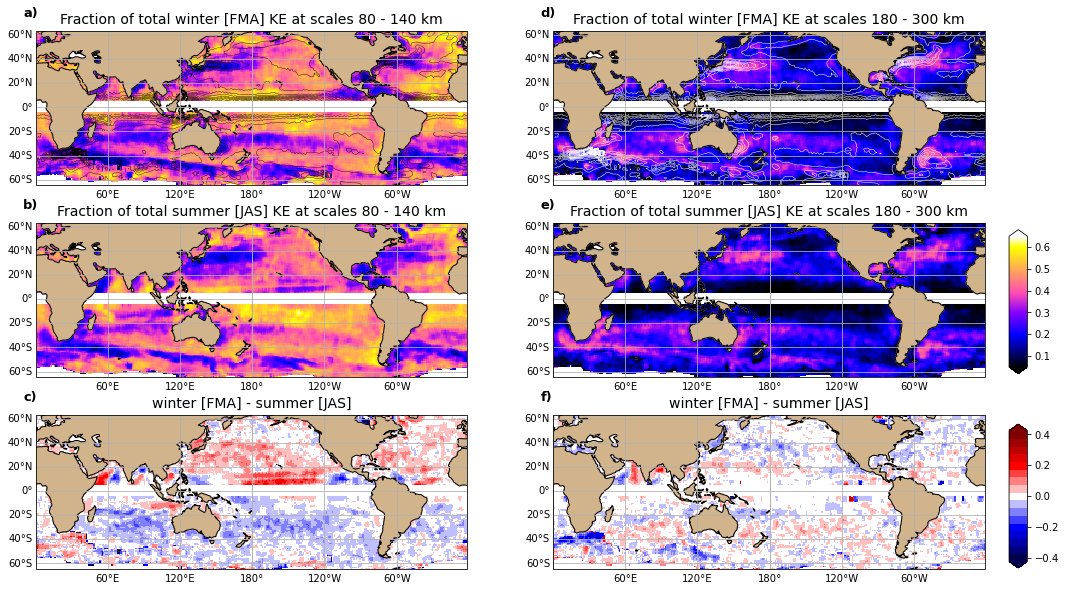

In [6]:
# seaonal changes in percent of energy in bands
land_col = '#D3D3D3'
lev2 = np.arange(0.05, 0.65, 0.001)
dlev1 = np.arange(1, 1001, 1)
tcmap2 = plt.get_cmap('gnuplot2')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]

# -- unfiltered KE 
mean_raw_mask = np.nanmean(total_ke,axis=0) 
mean_raw_mask[:, v_in] = np.nan
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
test_xr = xr.DataArray(data=np.transpose(mean_raw_mask), name='total_ke', dims=['latitude', 'longitude'], coords=data_coords)

mean_mf_mask0 = meso_frac0.copy() 
mean_mfwin_mask0 = smaller_frac0_win.copy()
mean_mfsum_mask0 = smaller_frac0_sum.copy()
mean_mf_mask1 = meso_frac1.copy() 
mean_mfwin_mask1 = smaller_frac1_win.copy()
mean_mfsum_mask1 = smaller_frac1_sum.copy()
# mask equator 
mean_mf_mask0[:, v_in] = np.nan
mean_mfwin_mask0[:, v_in] = np.nan
mean_mfsum_mask0[:, v_in] = np.nan
mean_mf_mask1[:, v_in] = np.nan
mean_mfwin_mask1[:, v_in] = np.nan
mean_mfsum_mask1[:, v_in] = np.nan
# check/remove nans 
bad_check = mean_mfwin_mask1 - mean_mfsum_mask1
for i in range(np.shape(mean_mfwin_mask1)[1]):
    bad = np.where(np.abs(bad_check[:, i]) > .34)[0]
    bad_check[bad, i] = np.nan
    bad_check[bad, i] = np.nan
land_cmap2 = plt.cm.get_cmap('viridis')
land_cmap2.set_over('#D3D3D3')

data_coords = {'latitude': lat_bins[1:-1], 'longitude': lon_bins[1:-1]}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
mfwin_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwin1_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask1), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum1_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask1), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum1_xr = xr.DataArray(data=np.transpose(bad_check), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)  # mean_mfwin_mask1 - mean_mfsum_mask1
# -- FIGURE -- 
f, ax = plt.subplots(3,2,figsize=(17,10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# -- column 0 
axpmf = mfwin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,0],transform=ccrs.PlateCarree(), \
                                                             vmin=lev2[0], vmax=lev2[-1], \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False)
ax[0,0].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
                                                        levels=np.arange(0.01,1,0.04), \
                                                        linewidths=0.4,colors='k',zorder=1)
ax[0,0].set_title(r"Fraction of total winter [FMA] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km", fontsize=14)

mfsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,0],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,0].set_title(r"Fraction of total summer [JAS] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km", fontsize=14)
 
mfwinsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,0],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,0].set_title(r"winter [FMA] - summer [JAS]", fontsize=14)
# # -- column 1
mfwin1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[0,1].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
                                                        levels=np.arange(0.01,1,0.04), \
                                                        linewidths=0.5,colors='w',zorder=1)
ax[0,1].set_title(r"Fraction of total winter [FMA] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km", fontsize=14)

mfsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,1].set_title(r"Fraction of total summer [JAS] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km", fontsize=14)
 
axpmfd = mfwinsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,1],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,1].set_title(r"winter [FMA] - summer [JAS]", fontsize=14)

for axi in ax.flatten():
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

cbpos = [0.92, 0.4, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='both')
cbpos = [0.92, 0.13, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmfd, cax=cax, orientation='vertical', extend='both')
ax[0,0].text(-190, 75, 'a)', fontweight='bold', fontsize=13)
ax[1,0].text(-190, 75, 'b)', fontweight='bold', fontsize=13)
ax[2,0].text(-190, 75, 'c)', fontweight='bold', fontsize=13)
ax[0,1].text(-190, 75, 'd)', fontweight='bold', fontsize=13)
ax[1,1].text(-190, 75, 'e)', fontweight='bold', fontsize=13)
ax[2,1].text(-190, 75, 'f)', fontweight='bold', fontsize=13)
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_along_track_gridding_seasonal_percent_ke_2.jpg', dpi=550)

In [464]:
# -- peak eke month -- 
# scales to map
scale1 = np.where(coarsening_factors == 3)[0]
scale2 = np.where(coarsening_factors == 15)[0]
pct_diff_cutoff = 0.25
# find month that has most eke at each scale 
max_month_1 = np.nan * np.ones(np.shape(eke[0, :, :, 0]))
max_month_2 = np.nan * np.ones(np.shape(eke[0, :, :, 0]))
for i in range(np.shape(eke)[1]):
    for j in range(np.shape(eke)[2]):
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(eke[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(eke[:, i, j, scale1]) - np.nanmin(eke[:, i, j, scale1]))/np.nanmean(eke[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(eke[:, i, j, scale1] == np.nanmax(eke[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                max_month_1[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_1[i, j] = this_ij + 1
        # -- scale2 (larger) 
        if (~np.isnan(np.nanmax(eke[:, i, j, scale2]))) & \
        (np.abs(np.nanmax(eke[:, i, j, scale2]) - np.nanmin(eke[:, i, j, scale2]))/np.nanmean(eke[:, i, j, scale2]) > pct_diff_cutoff):
            test = eke[:, i, j, scale2] - eke[:, i, j, scale1]  # difference between scales 
            this_ij = np.where(test == np.nanmax(test))[0]
            if len(this_ij) > 1:
                max_month_2[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_2[i, j] = this_ij + 1

# put output in xarray
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr_s = np.where(((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < -5)))[0]
lat_xr_n = np.where(((lat_bins[1:-1] > 5) & (lat_bins[1:-1] < lat_n)))[0]
mm1_xr = xr.DataArray(data=np.transpose(max_month_1), name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
mm2_xr = xr.DataArray(data=np.transpose(max_month_2), name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
eqq = np.where((lat_bins[1:-1] > -2) & (lat_bins[1:-1] < 2))[0]

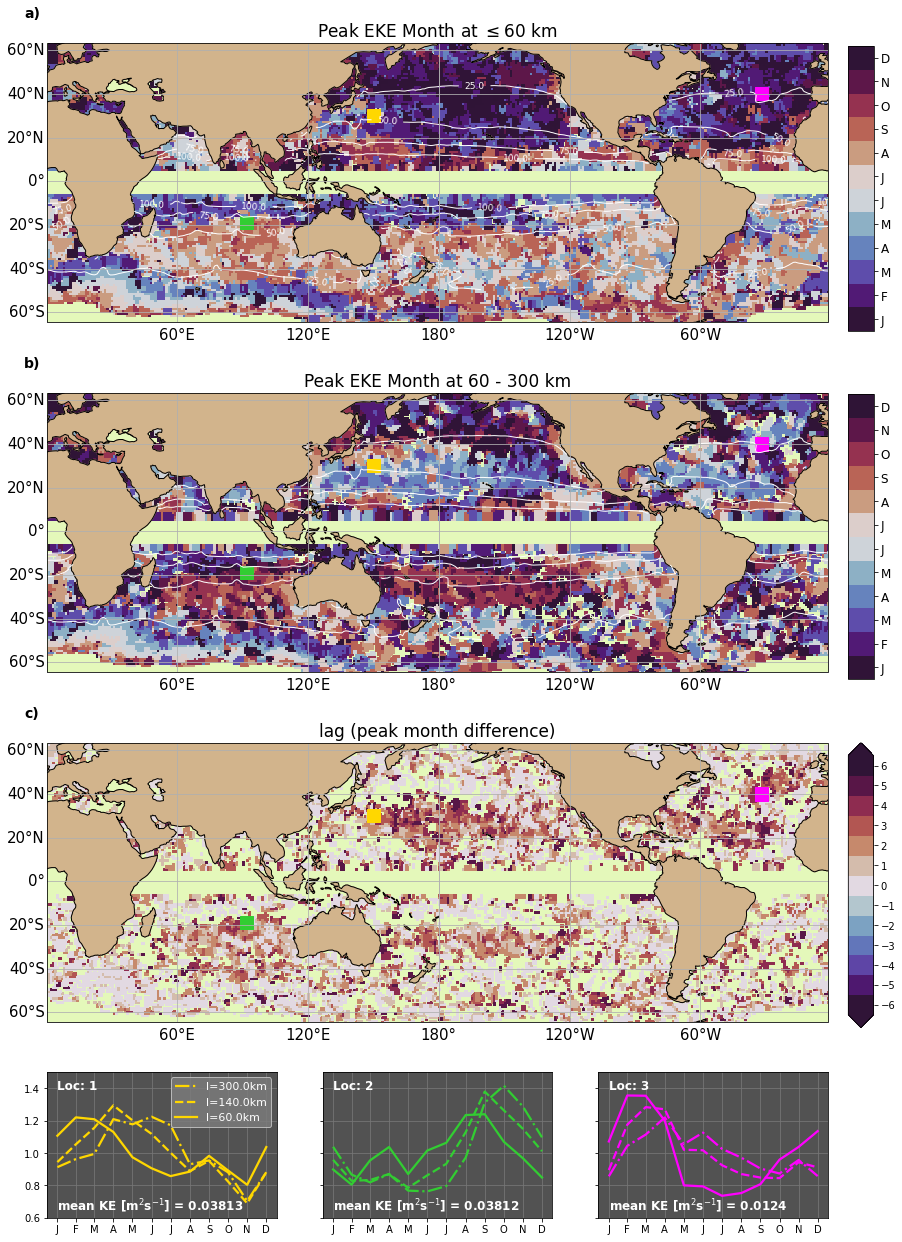

In [475]:
# ------------------------
# -- PLOT --        
# ------------------------
f = plt.figure(figsize=(14, 22))  # , constrained_layout=True)
gs = GridSpec(7, 3, figure=f)
ax1 = f.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = f.add_subplot(gs[2:4, :], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = f.add_subplot(gs[4:6, :], projection=ccrs.PlateCarree(central_longitude=180))
aa1 = f.add_subplot(gs[6, 0])
aa2 = f.add_subplot(gs[6, 1])
aa3 = f.add_subplot(gs[6, 2])
# - 1 - 
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
ax1.set_title('Peak EKE Month at $\leq$' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' km', fontsize=17)
dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')

# - 2-  
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
ax2.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax2.set_title('Peak EKE Month at ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' - ' + \
              str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + ' km', fontsize=17)

# check that 
mo_lag = max_month_2 - max_month_1
for i in range(np.shape(max_month_2)[0]):
    pos_lag_easy = np.where(max_month_2[i, :] > max_month_1[i, :])[0]
    lag_hard1 = np.where( (max_month_1[i, :] >= 9.0) & (max_month_2[i, :] <= 6.0) )[0]
    lag_hard2 = np.where( (max_month_2[i, :] >= 9.0) & (max_month_1[i, :] <= 6.0) )[0]
    mo_lag[i, lag_hard1] = mo_lag[i, lag_hard1] + 12
    mo_lag[i, lag_hard2] = mo_lag[i, lag_hard2] - 12
mo_lag_ref = mo_lag.copy()
# - 3 - 
mo_lag[mo_lag < 0] = np.nan
mo_lag[mo_lag > 5] = np.nan
cmap_lag = plt.get_cmap('twilight_shifted',13)
lag_tp = [-6.5,6.5]
mol_xr = xr.DataArray(data=np.transpose(mo_lag), name='lag', dims=['latitude', 'longitude'], coords=data_coords) 
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
ax3.set_title('lag (peak month difference)', fontsize=17)
ax3.set_xlabel('Longitude [$^{\circ}$]',fontsize=14)
ax3.set_ylabel('Latitude [$^{\circ}$]',fontsize=14)
# colorbars 
cbpos0 = [0.92, 0.685, 0.025, 0.18]
cbpos = [0.92, 0.465, 0.025, 0.18]
cbpos2 = [0.92, 0.245, 0.025, 0.18]

cax0 = f.add_axes(cbpos0)
cax = f.add_axes(cbpos)
cax2 = f.add_axes(cbpos2)
cb0 = f.colorbar(axp0, cax=cax0, orientation='vertical', extend='neither', ticks=np.arange(1,13))
cb0.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8],month_labels[9],month_labels[10],month_labels[11]], fontsize=12)

cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='neither', ticks=np.arange(1,13))
cb.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8],month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
cb2 = f.colorbar(axp2, cax=cax2, orientation='vertical', extend='both', ticks=np.arange(-6,7))
# -- formatting 
for axi in ax1, ax2, ax3:
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), \
                np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    gl.xlabels_top = False
    gl.ylabels_right = False
ax1.text(-190, 75, 'a)', fontweight='bold', fontsize=14)
ax2.text(-190, 75, 'b)', fontweight='bold', fontsize=14)
ax3.text(-190, 75, 'c)', fontweight='bold', fontsize=14)

# -- inset subplots with seasonal cycles 
colors2 = ['r', '#FFD700', '#32CD32', '#FF00FF']  # '#00FF00'
for i in [1,2,3]:  # range(len(order[0:5])):
    this_lon0 = location[i, 0] - 1
    this_lon1 = location[i, 1] + 1
    this_lat0 = location[i, 2] - 1 
    this_lat1 = location[i, 3] + 1
    for axi in [ax1, ax2, ax3]:
        axi.fill_between([this_lon0, this_lon1], [this_lat0, this_lat0], [this_lat1, this_lat1], color=colors2[i], transform=ccrs.PlateCarree())

to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
ibc = '#525252'
aa1.set_facecolor(ibc)
aa2.set_facecolor(ibc)
aa3.set_facecolor(ibc)
i = 1
for ai in [aa1, aa2, aa3]:
    ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                 np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[0]]*hor_grid_spacing) + 'km', linestyle='-.', linewidth=2.25)
    ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                 np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[1]]*hor_grid_spacing) + 'km', linestyle='--', linewidth=2.25)
    ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                 np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[2]]*hor_grid_spacing) + 'km', linewidth=2.25)
    ai.text(frac_year[0], 0.65, 'mean KE [m$^2$s$^{-1}$] = ' + \
            str(np.round(np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]]), 5)), fontweight='bold', fontsize=12, color='w')
    ai.set_xticks(frac_year)
    ai.set_xticklabels(month_labels)
    ai.set_ylim([0.6, 1.5])
    ai.text(frac_year[0], 1.39, 'Loc: ' + str(i), fontweight='bold', fontsize=12, color='w')
    ai.grid(color='#767676')
    i = i + 1
handles, labels = aa1.get_legend_handles_labels()
ll = aa1.legend(handles, labels, fontsize=11, facecolor='#7d7d7d')
for text in ll.get_texts():
    text.set_color("w")
aa3.set(yticklabels=[])
aa2.set(yticklabels=[])
outt = '#e4f8ba' # '#b4f3c7'
ax1.set_facecolor(outt)
ax2.set_facecolor(outt)
ax3.set_facecolor(outt)          
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_max_eke_month_diff_w_loc_60_140_300.jpg', dpi=500)
# f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_max_eke_month_diff_w_loc_60_140_300_r1.jpg', dpi=500)

In [147]:
np.shape(pe)

(12, 145, 360)

In [535]:
# ARGO MLD 
f_argo_pe = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APE.nc'
argo_pe = xr.open_dataset(f_argo_pe)
pe_lon = argo_pe.lon.longitude.data
pe_lat = argo_pe.lat.latitude.data
pe = argo_pe['pe'].data
ape_rate = argo_pe['ape_rate'].data

from altimetry_tools import Filter
pe_mean = np.nanmean(pe, axis=0)
pe_smooth = np.nan * np.ones(np.shape(pe_mean))
for i in range(np.shape(pe_mean)[0]):
    ff1 = Filter('Gaussian', [pe_mean[i,:][None,:]], 1, 20, plot_filter=0) 
    pe_smooth[i,:] = ff1[0]
for j in range(np.shape(pe_mean)[1]):
    ff1 = Filter('Gaussian', [pe_mean[:,j][None,:]], 1, 20, plot_filter=0) 
    pe_smooth[:,j] = ff1[0]

Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N,

Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N,

Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N,

Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 26 If d>2 or X is not pi then results might not be accurate.
Using default N,

In [441]:
np.shape(pe_mean)

(145, 360)

In [224]:
meso_band0_i = np.where((coarsening_factors <= 6) & (coarsening_factors >= 3))[0] # was (7,4) 80-160 km 
loc_var_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
loc_tot_var_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c)))
smaller_frac0_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]      
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2   
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        
        for m in range(len(frac_year)):
            loc_var_bm[m, i, j, :] = filtered_ke[m][kk, :, :][:, ll, :]
            loc_tot_var_bm[m, i, j] = total_ke[m][kk, :][:, ll]
            # 'spectra' as a function of filter scale 
            this_spec_bm = loc_var_bm[m, i, j, :][None, :]
            # area under the curve 
            sample_band_bm = (this_spec_bm[0, 1:] - this_spec_bm[0, 0:-1])
            # sum band passed variance estimate 
            # smaller_frac0_bm[m,i,j] = np.sum(sample_band_bm[meso_band0_i])/loc_tot_var_bm[m,i,j]
            # - smallest scale up to 120 km
            smaller_frac0_bm[m,i,j] = np.sum(sample_band_bm[meso_band0_i[0]:])/loc_tot_var_bm[m,i,j]
        
        
mean_mf_bm_mask0 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_mf_bm_mask0_i = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        mean_mf_bm_mask0[i,j] = np.nanmax(smaller_frac0_bm[:,i,j]) - np.nanmin(smaller_frac0_bm[:,i,j])
        if (np.sum(np.isnan(smaller_frac0_bm[:,i,j])) < 4) & (np.nanmean(smaller_frac0_bm[:,i,j]) > 0):
            mean_mf_bm_mask0_i[i,j] = np.where(smaller_frac0_bm[:,i,j] == np.nanmax(smaller_frac0_bm[:,i,j]))[0]
mfmaxmin_xr = xr.DataArray(data=np.transpose(mean_mf_bm_mask0), \
                           name='small_eke_diff', dims=['latitude', 'longitude'], coords=data_coords)
mfmaxmonth_xr = xr.DataArray(data=np.transpose(mean_mf_bm_mask0_i), \
                           name='small_eke_max_month', dims=['latitude', 'longitude'], coords=data_coords)

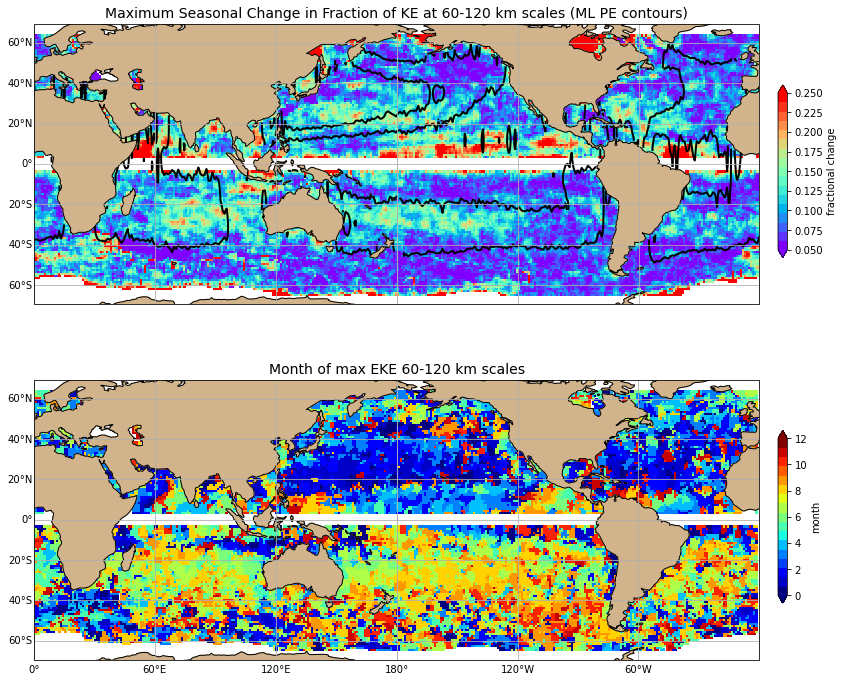

In [443]:
# ALIGNMENT WITH ARGO 
cmap_sea = plt.get_cmap('plasma',13)
# mfwinsum_xr
f, (ax,ax2) = plt.subplots(2,1,figsize=(13,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axp=mfmaxmin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax,transform=ccrs.PlateCarree(), \
                                                      vmin=0.05, vmax=0.25, \
                                                      cmap=plt.get_cmap('rainbow',17), zorder=0, add_colorbar=False) # -0.425

# -- mld difference * ml density differnce (sylvia's method)
ax.contour(pe_lon,pe_lat,pe_smooth,levels=[7500, 15000],\
            linewidths=2,zorder=2,transform=ccrs.PlateCarree(),colors='k') # levels=[100,200] colors='r',linewidths=1.5,

# r1 = np.where(mld_lon < 0)[0]
# mld_test = np.concatenate((mld_energy_smooth[:,r1[-1]+1:], mld_energy_smooth[:,r1]),axis=1)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.6, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='fractional change')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax.set_title('Maximum Seasonal Change in Fraction of KE at 60-120 km scales (ML PE contours)', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabels_bottom = False

# Figure 2 
axp=mfmaxmonth_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax2,transform=ccrs.PlateCarree(), \
                                                      vmin=0, vmax=12, \
                                                      cmap=plt.get_cmap('jet',17), zorder=0, add_colorbar=False) # -0.425
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
cbpos = [0.92, 0.2, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='month')
ax2.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax2.set_title('Month of max EKE 60-120 km scales', fontsize=14)
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False

# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/small_scale_eke_2.jpg', dpi=500)

Text(0.5, 1.0, 'Month of max EKE 60-120 km scales')

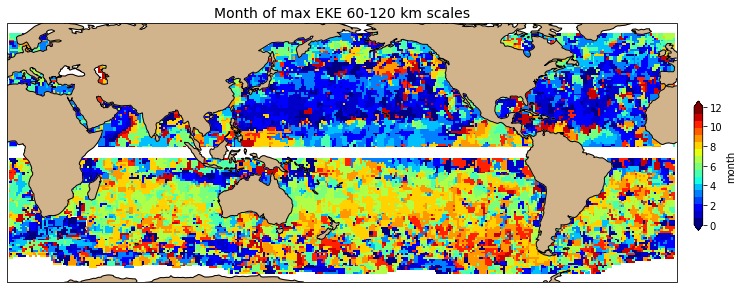

In [227]:
# month of small eke max  
cmap_sea = plt.get_cmap('plasma',13)
# mfwinsum_xr
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axp=mfmaxmonth_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax,transform=ccrs.PlateCarree(), \
                                                      vmin=0, vmax=12, \
                                                      cmap=plt.get_cmap('jet',17), zorder=0, add_colorbar=False) # -0.425
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.322, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='month')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax.set_title('Month of max EKE 60-120 km scales', fontsize=14)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/small_scale_eke_2.jpg', dpi=500)

In [527]:
eke_small_smooth = np.nan * np.ones(np.shape(mean_mf_bm_mask0))
for i in range(np.shape(pe_mean)[1]):
    ff1 = Filter('Gaussian', [mean_mf_bm_mask0[i,:][None,:]], 1, 2, plot_filter=0) 
    eke_small_smooth[i,:] = ff1[0]
for j in range(np.shape(pe_mean)[2]):
    ff1 = Filter('Gaussian', [mean_mf_bm_mask0[:,j][None,:]], 1, 2, plot_filter=0) 
    eke_small_smooth[:,j] = ff1[0]

Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>

Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>

IndexError: tuple index out of range

In [536]:
[ii, ai, bi] = np.intersect1d(pe_lat,lat_bin_c[1:-1],return_indices=True)

In [537]:
mean_pe = pe_smooth
r1 = np.where(pe_lon > 360)[0]
pe_ra = np.concatenate((mean_pe[:,r1], mean_pe[:,0:r1[0]]),axis=1)

In [538]:
print(np.shape(np.transpose(mean_mf_bm_mask0)[bi,:]))
print(np.shape(win_m_sum_80_160))
print(np.shape(lat_bin_c))

(134, 360)
(140, 360)
(140,)


In [551]:
# win_m_sum_80_160 = np.transpose(mean_mfwin_mask0[:,0:-1] - mean_mfsum_mask0[:,0:-1])
win_m_sum_80_160 = np.transpose(eke_small_smooth) # np.transpose(mean_mf_bm_mask0)
overlap_x,overlap_y = np.where((pe_ra[ai,:]>np.nanmean(pe_ra)) & (np.abs(win_m_sum_80_160[bi,:]) > 0.11))
test_m = np.zeros(np.shape(win_m_sum_80_160[bi,:]))
for i in range(len(overlap_x)):
    test_m[overlap_x[i],overlap_y[i]] = 1

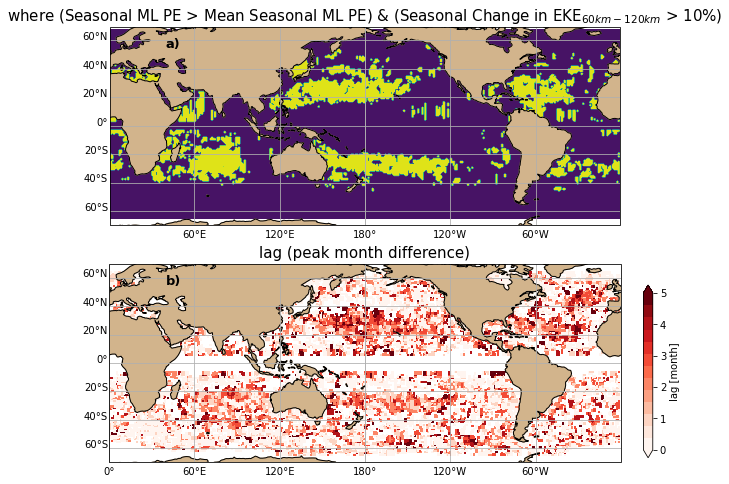

In [558]:
f, (ax,ax2) = plt.subplots(2,1,figsize=(13,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax.contourf(lon_bin_c,lat_bin_c[bi], test_m,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.set_title(r'where (Seasonal ML PE > Mean Seasonal ML PE) & (Seasonal Change in EKE$_{60km-120km}$ > 10%)',\
             fontsize=15)
ax.coastlines()
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False

cmap_lag = plt.get_cmap('Reds',13)
lag_tp = [0,5] # [-6.5,6.5]
mol_xr = xr.DataArray(data=np.transpose(mo_lag), name='lag', dims=['latitude', 'longitude'], coords=data_coords) 
lag_map = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax2,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
mol_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax2,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
# ax2.contour(lon_bin_c,lat_bin_c[bi], test_m,levels=[1],transform=ccrs.PlateCarree(),color='k',linewidths=1)
ax2.set_title('lag (peak month difference)', fontsize=15)
ax2.set_xlabel('Longitude [$^{\circ}$]',fontsize=14)
ax2.set_ylabel('Latitude [$^{\circ}$]',fontsize=14)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
ax2.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False
cbpos = [0.81, 0.132, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(lag_map, cax=cax, \
                orientation='vertical', extend='both', \
                label='lag [month]')
ax.text(40, 55, 'a)', fontsize=13, fontweight='bold', transform=ccrs.PlateCarree())
ax2.text(40, 55, 'b)', fontsize=13, fontweight='bold', transform=ccrs.PlateCarree())
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/region_overlap_2.jpg', dpi=500)

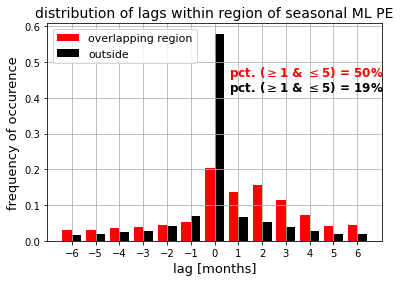

In [557]:
lag_list = []
outside_list = []
mo_lag_trim = np.transpose(mo_lag_ref[:,bi].copy())
mo_lag_trim[np.isnan(mo_lag_trim)] = 0
for i in range(len(overlap_x)):
    lag_list.append(mo_lag_trim[overlap_x[i],overlap_y[i]])
for i in range(np.shape(test_m)[0]):
    if i < 1:
        outside_list = mo_lag_trim[i,test_m[i,:] < 1]
    else:
        outside_list = np.concatenate((outside_list, mo_lag_trim[i, test_m[i,:] < 1]))

f, ax = plt.subplots()
ax.hist([lag_list, outside_list],bins=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7], \
        density=True,align='left', color=['r', 'k'], label=['overlapping region', 'outside']) # [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
# ax.hist(mo_lag_ref.flatten(),bins=np.arange(-10,10),density=True, align='right')
# ax.set_ylim([0, 10000])
ax.set_xticks(np.arange(-6,7,1))
# ax.set_xticks(np.arange(0,7,1))
# ax.set_xticklabels(np.arange(0,6,1))
handles, labels = ax.get_legend_handles_labels()
ll = ax.legend(handles, labels, fontsize=11,loc=2)
ax.grid()
ax.set_xlabel('lag [months]',fontsize=13)
ax.set_ylabel('frequency of occurence',fontsize=13)
ax.set_title('distribution of lags within region of seasonal ML PE',fontsize=14)
ax.text(0.6,.46,'pct. ($\geq$1 & $\leq$5) = 50%',fontsize=12, color='r', fontweight='bold')
ax.text(0.6,.42,'pct. ($\geq$1 & $\leq$5) = 19%',fontsize=12, color='k', fontweight='bold')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/pct_lag_in_pe_regions.jpg', dpi=500)

In [555]:
print(len(np.where((np.array([lag_list]) >= 1) & (np.array([lag_list]) <= 5))[0])/len(lag_list))
print(len(np.where((np.array([outside_list]) >= 1) & (np.array([outside_list]) <= 5))[0])/len(outside_list))

0.4936990363232024
0.19477639809541591
